In [1]:
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import json

In [2]:
NAIVE_COLOR: str = "red"
GRAPH_COLOR: str = "blue"
U_ETH_SPACE = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
NUMS_OF_TOKENS_SPACE = list(range(3, 13))
COLUMNS_ID = [
    'block_number', 'num_of_tokens', 'u_eth',
    'expected_gas', 'token_in', 'amount_in', 'amount_out', 'return_precost'
]

In [3]:
def json_to_df(json_data):
    flatten_list = []
    for item in json_data:
        item_meta = item.copy()
        del item_meta["arbitrages"]
        for arb in item["arbitrages"]:
            new_item = item_meta.copy()
            new_item.update(arb)
            flatten_list.append(
                new_item
            )
    return pd.DataFrame(flatten_list).drop_duplicates(subset = COLUMNS_ID)

def json_to_meta_df(json_data):
    return pd.DataFrame(json_data)

def make_df(filenames: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_flat = pd.DataFrame()
    df_meta = pd.DataFrame()
    for filename in filenames:
        try:
            with open(filename) as f:
                json_data = json.load(f)
                df_flat = pd.concat(
                    [
                        df_flat,
                        json_to_df(json_data)
                    ]
                )
                df_meta = pd.concat(
                    [
                        df_meta,
                        json_to_meta_df(json_data)
                    ]
                )
        except FileNotFoundError:
            continue
    df_flat = df_flat.assign(
        eth_return_precost = lambda df: df["u_eth"].mul(df["return_precost"])
    )

    return df_meta, df_flat

In [4]:
filenames_bf = [
    f"data/bf_test_{num_of_tokens}_{u_eth}.json"
    for num_of_tokens in NUMS_OF_TOKENS_SPACE
    for u_eth in U_ETH_SPACE
]

filenames_naive = [
    f"data/naive_test_{num_of_tokens}_1.json"
    for num_of_tokens in NUMS_OF_TOKENS_SPACE
]

graph_meta_df, graph_df = make_df(filenames_bf)
naive_meta_df, naive_df = make_df(filenames_naive)

## BF Runtime vs Number of Tokens

Text(0.5, 1.0, 'Runtime')

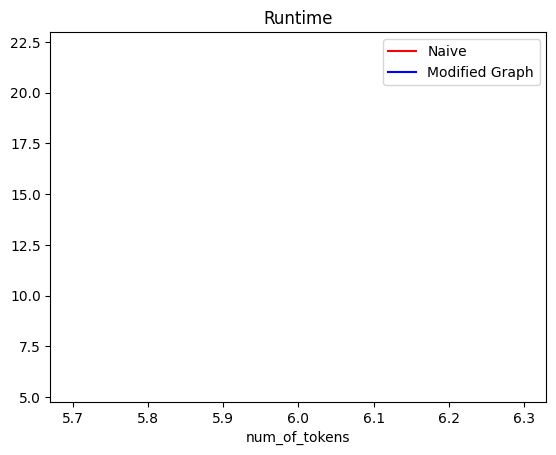

In [24]:
naive_meta_df.groupby(["num_of_tokens"])["time"].mean().plot(color = NAIVE_COLOR)
graph_meta_df.groupby(["num_of_tokens"])["time"].mean().plot(color = GRAPH_COLOR)
plt.legend(["Naive", "Modified Graph"])
plt.title("Runtime")

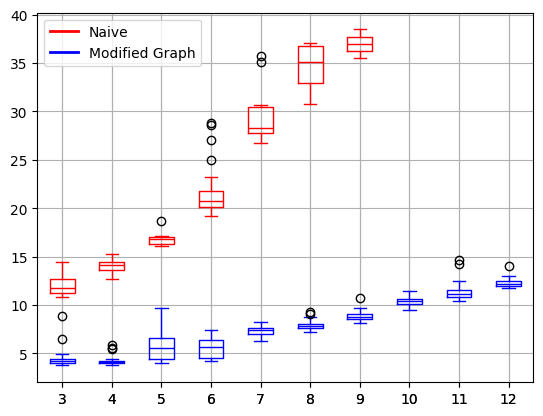

In [6]:
naive_box = naive_meta_df.groupby(["block_number", "num_of_tokens"])["time"].mean().reset_index().pivot(
    index = "block_number",
    columns = "num_of_tokens",
    values = "time"
).assign(
    **{
        str(i): np.nan
        for i in range(10, 13)
    }
).boxplot(color = NAIVE_COLOR)
bf_box = graph_meta_df.groupby(["block_number", "num_of_tokens"])["time"].mean().reset_index().pivot(
    index = "block_number",
    columns = "num_of_tokens",
    values = "time"
).boxplot(color = GRAPH_COLOR)

custom_lines = [Line2D([0], [0], color=NAIVE_COLOR, lw=2),
            Line2D([0], [0], color=GRAPH_COLOR, lw=2)]
plt.legend(custom_lines, ["Naive", "Modified Graph"])

In [7]:
naive_time_df = naive_meta_df.assign(
    ln_num_of_tokens = lambda df: df["num_of_tokens"].pipe(np.log)
)

OLS(
    naive_time_df["time"],
    naive_time_df["num_of_tokens"].pipe(lambda x: np.power(x, 1))
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   time   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              5570.
Date:                Tue, 02 Apr 2024   Prob (F-statistic):                    9.82e-83
Time:                        20:12:52   Log-Likelihood:                         -221.01
No. Observations:                  91   AIC:                                      444.0
Df Residuals:                      90   BIC:                                      446.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_of_tokens     3.7715      0.051     74.630      0.000       3.671       3.872
==============================================================================
Omnibus:                       29.983   Durbin-Watson:                   0.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.978
Skew:                           1.479   Prob(JB):                     1.04e-10
Kurtosis:                       4.839   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
graph_time_df = graph_meta_df.assign(
    ln_num_of_tokens = lambda df: df["num_of_tokens"].pipe(np.log)
)

OLS(
    graph_time_df["time"],
    graph_time_df["num_of_tokens"].pipe(lambda x: np.power(x, 1))
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   time   R-squared (uncentered):                   0.907
Model:                            OLS   Adj. R-squared (uncentered):              0.907
Method:                 Least Squares   F-statistic:                          4.413e+04
Date:                Tue, 02 Apr 2024   Prob (F-statistic):                        0.00
Time:                        20:12:52   Log-Likelihood:                         -10768.
No. Observations:                4510   AIC:                                  2.154e+04
Df Residuals:                    4509   BIC:                                  2.154e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_of_tokens     1.0262      0.005    210.064      0.000       1.017       1.036
==============================================================================
Omnibus:                     2483.093   Durbin-Watson:                   0.499
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30885.688
Skew:                           2.369   Prob(JB):                         0.00
Kurtosis:                      14.913   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='block_number'>

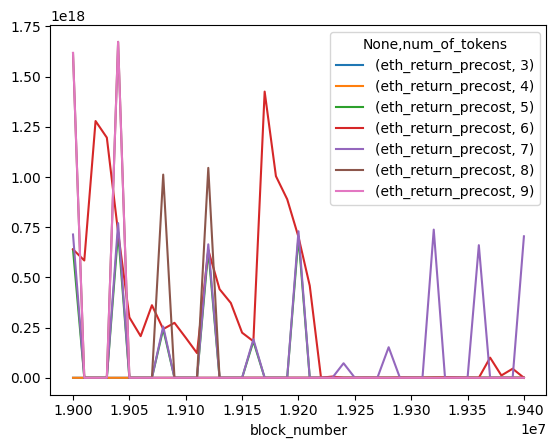

In [9]:
naive_df.groupby(["num_of_tokens", "block_number"])["eth_return_precost"].sum().reset_index().pivot_table(
    index = "block_number", columns = "num_of_tokens"
).fillna(0).plot()

<Axes: xlabel='block_number'>

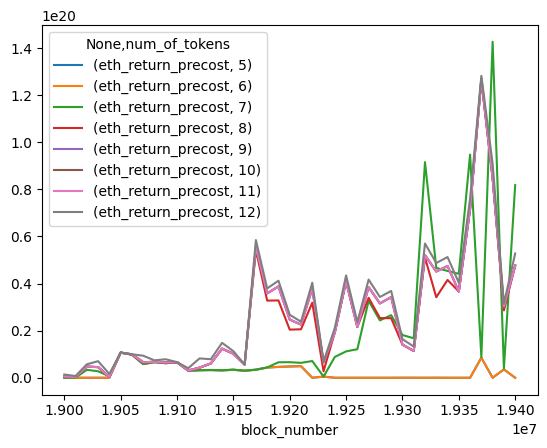

In [10]:
graph_df.groupby(["num_of_tokens", "block_number"])["eth_return_precost"].sum().reset_index().pivot_table(
    index = "block_number", columns = "num_of_tokens"
).fillna(0).plot()

## Analysis of U

## Modified Graph vs Naive

In [11]:
u_eth_space = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
num_of_tokens_space = list(range(3, 13))
naive_fixed_num = 6
filenames_bf = [
    f"data/bf_test_{naive_fixed_num}_{u_eth}.json"
    for u_eth in u_eth_space
]

filenames_naive = [
    f"data/naive_test_{naive_fixed_num}_{u_eth}.json"
    for u_eth in u_eth_space
]

graph_meta_df, graph_df = make_df(filenames_bf)
naive_meta_df, naive_df = make_df(filenames_naive)

<Axes: xlabel='block_number,u_eth'>

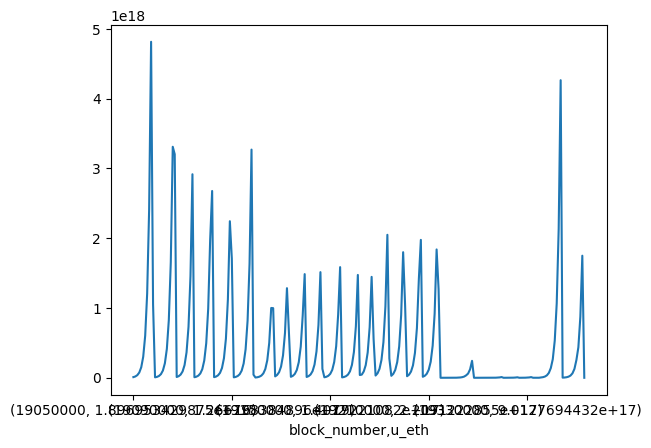

In [12]:
graph_df.groupby(["block_number", "u_eth"])["eth_return_precost"].sum().plot()

In [13]:
stats_df = naive_df.groupby(["block_number", "u_eth"])["eth_return_precost"].sum().reset_index().merge(
    graph_df.groupby(["block_number", "u_eth"])["eth_return_precost"].sum(),
    on = ["block_number", "u_eth"],
    suffixes = ["_naive", "_graph"],
    how = "left"
).fillna(0).assign(
    log_u_eth = lambda df: df["u_eth"].pipe(np.log),
    eth_return_precost_ratio = lambda df: df["eth_return_precost_graph"].div(df["eth_return_precost_naive"])
).groupby("block_number").apply(
    lambda df: df.assign(
        u_eth_min = lambda x: x["u_eth"].min()
    )
).assign(
    u_eth_norm = lambda df: df["u_eth"].div(df["u_eth_min"]).mul(U_ETH_SPACE[0])
).assign(
    log_u_eth_norm = lambda df: df["u_eth_norm"].pipe(np.log)
).reset_index(drop = True)

<Axes: xlabel='log_u_eth_norm'>

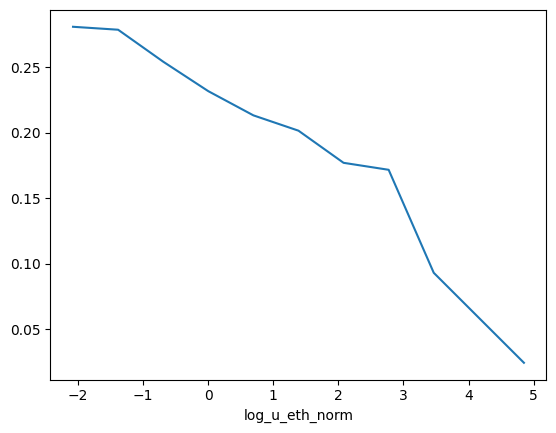

In [14]:
stats_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_ratio").fillna(0).mean().plot()

<Axes: xlabel='block_number,u_eth'>

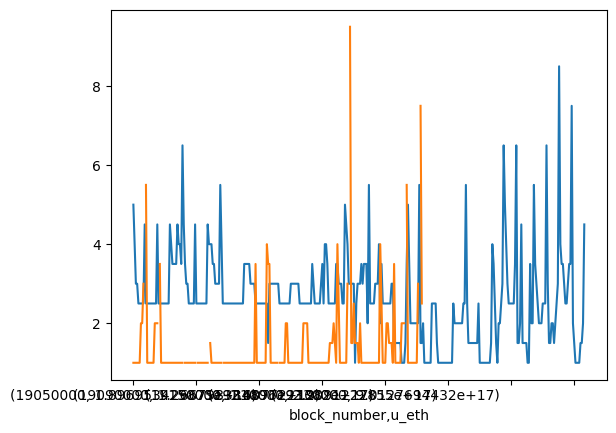

In [23]:
naive_df.groupby(["block_number", "u_eth"]).apply(
    lambda df: df.assign(
        arb_rank = lambda x: x["eth_return_precost"].rank(ascending = False)
    ).sort_values("arb_rank")
).reset_index(drop = True).groupby(["block_number", "u_eth"])["arb_rank"].mean().plot()
graph_df.merge(
    naive_df.groupby(["block_number", "u_eth"]).apply(
        lambda df: df.assign(
            arb_rank = lambda x: x["eth_return_precost"].rank(ascending = False)
        ).sort_values("arb_rank")
    ).reset_index(drop = True),
    how = "left",
    on = COLUMNS_ID,
    suffixes = ["_graph", "_naive"]
).groupby(["block_number", "u_eth"])["arb_rank"].mean().plot()

<Axes: xlabel='block_number,u_eth'>

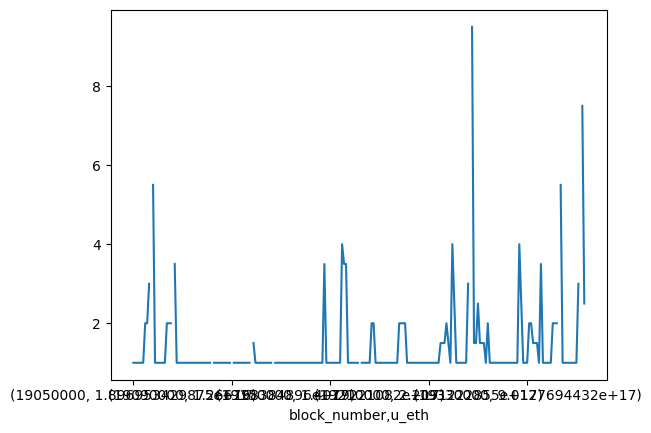

In [19]:
graph_df.merge(
    naive_df.groupby(["block_number", "u_eth"]).apply(
        lambda df: df.assign(
            arb_rank = lambda x: x["eth_return_precost"].rank(ascending = False)
        ).sort_values("arb_rank")
    ).reset_index(drop = True),
    how = "left",
    on = COLUMNS_ID,
    suffixes = ["_graph", "_naive"]
).groupby(["block_number", "u_eth"])["arb_rank"].mean().plot()